
# Pb+Pb (5.02 TeV) vs Au+Au (200 GeV): centrality systematics in large systems

Author: **Sabin Thapa** (Kent State University) — `sthapa3@kent.edu`

## What this notebook is for

Large nuclei have a wide range of overlap geometries as impact parameter b changes.
Therefore optical b-percentile centrality is a good first-principles approximation and you should see:

- strong centrality dependence of overlap area
- strong centrality dependence of eccentricity and profile shape
- strong changes in peak and integrated ε(x,y,ζ=0)

We compute:
- optical centrality tables (⟨b⟩, ⟨Npart⟩, ⟨Ncoll⟩)
- tilted aHydro ε(x,y,ζ=0) for selected centralities
- x-slice overlays and a simple eccentricity diagnostic


In [1]:
import sys, pathlib
sys.path.insert(0, str(pathlib.Path('..').resolve()))


import numpy as np
import matplotlib.pyplot as plt

from src.plotting import set_pub_style, style_ax
from src.physics import DEFAULT_SIGMA_NN
from src.geometry import nucleus_from_name
from src.glauber_optical import OpticalGlauber, make_grid2d, integrate_2d
from src.initial_ahydro import TiltedParams, epsilon_tilted_slice

set_pub_style()


In [2]:

grid = make_grid2d(xmax=13, nx=261, ymax=13, ny=261)
zeta = np.linspace(-10.0, 10.0, 801)
CENT = np.arange(0, 101, 10)

Au = nucleus_from_name("Au")
Pb = nucleus_from_name("Pb")

sigma_AuAu = DEFAULT_SIGMA_NN.sigma_mb(200.0)
sigma_PbPb = DEFAULT_SIGMA_NN.sigma_mb(5020.0)

opt_AuAu = OpticalGlauber("AA", sigmaNN_mb=sigma_AuAu, nuc_target=Au, nuc_projectile=Au)
opt_PbPb = OpticalGlauber("AA", sigmaNN_mb=sigma_PbPb, nuc_target=Pb, nuc_projectile=Pb)

tab_AuAu = opt_AuAu.centrality_table(grid=grid, bmax=18.0, db=0.25, cent_edges=CENT)
tab_PbPb = opt_PbPb.centrality_table(grid=grid, bmax=20.0, db=0.25, cent_edges=CENT)

print("AuAu <b>:", np.round(tab_AuAu["b_mean"], 3))
print("PbPb <b>:", np.round(tab_PbPb["b_mean"], 3))


AuAu <b>: [ 3.005  5.672  7.394  8.761  9.881 10.88  11.88  12.879 13.746 15.041]
PbPb <b>: [ 3.171  5.92   7.643  9.14  10.381 11.508 12.502 13.379 14.369 15.8  ]


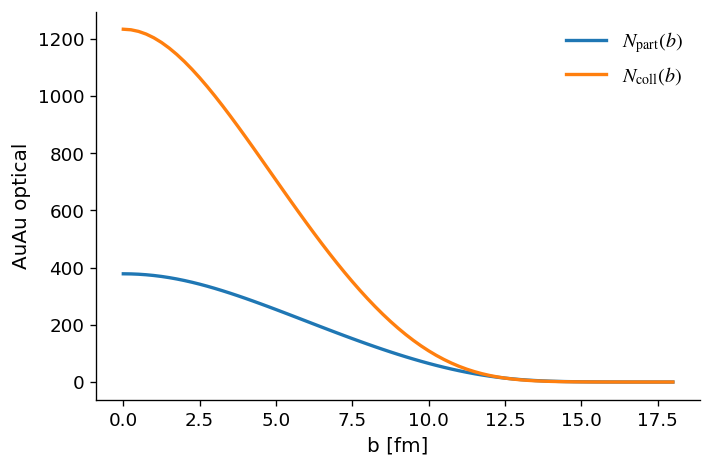

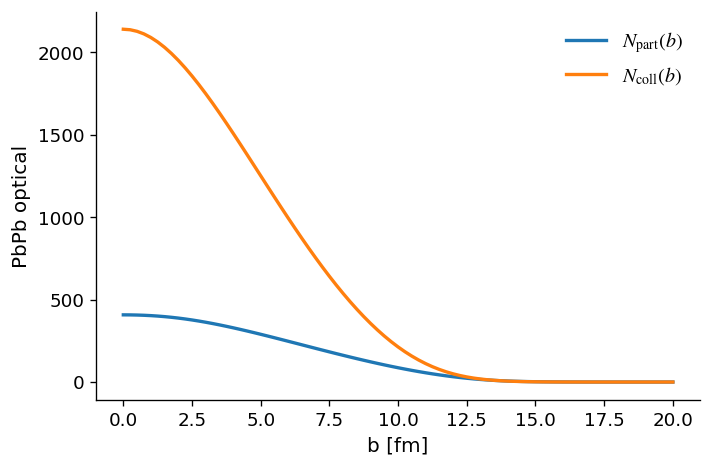

In [3]:

# Plot Npart(b) and Ncoll(b)
def plot_np_nc(tab, label):
    fig, ax = plt.subplots()
    ax.plot(tab["b_vals"], tab["Npart"], label=r"$N_{\mathrm{part}}(b)$")
    ax.plot(tab["b_vals"], tab["Ncoll"], label=r"$N_{\mathrm{coll}}(b)$")
    ax.set_xlabel("b [fm]")
    ax.set_ylabel(label)
    ax.legend()
    style_ax(ax)
    plt.show()

plot_np_nc(tab_AuAu, "AuAu optical")
plot_np_nc(tab_PbPb, "PbPb optical")



## Energy density ε(x,y,ζ=0) for selected centralities

We show both:
- fixed-scale normalization by the 0–10% peak (amplitude visible)
- peak-normalized per panel (shape only)

In AA, even the peak-normalized shapes change strongly with centrality because
the overlap geometry becomes increasingly elliptical and smaller as b grows.


AuAu fixed-scale


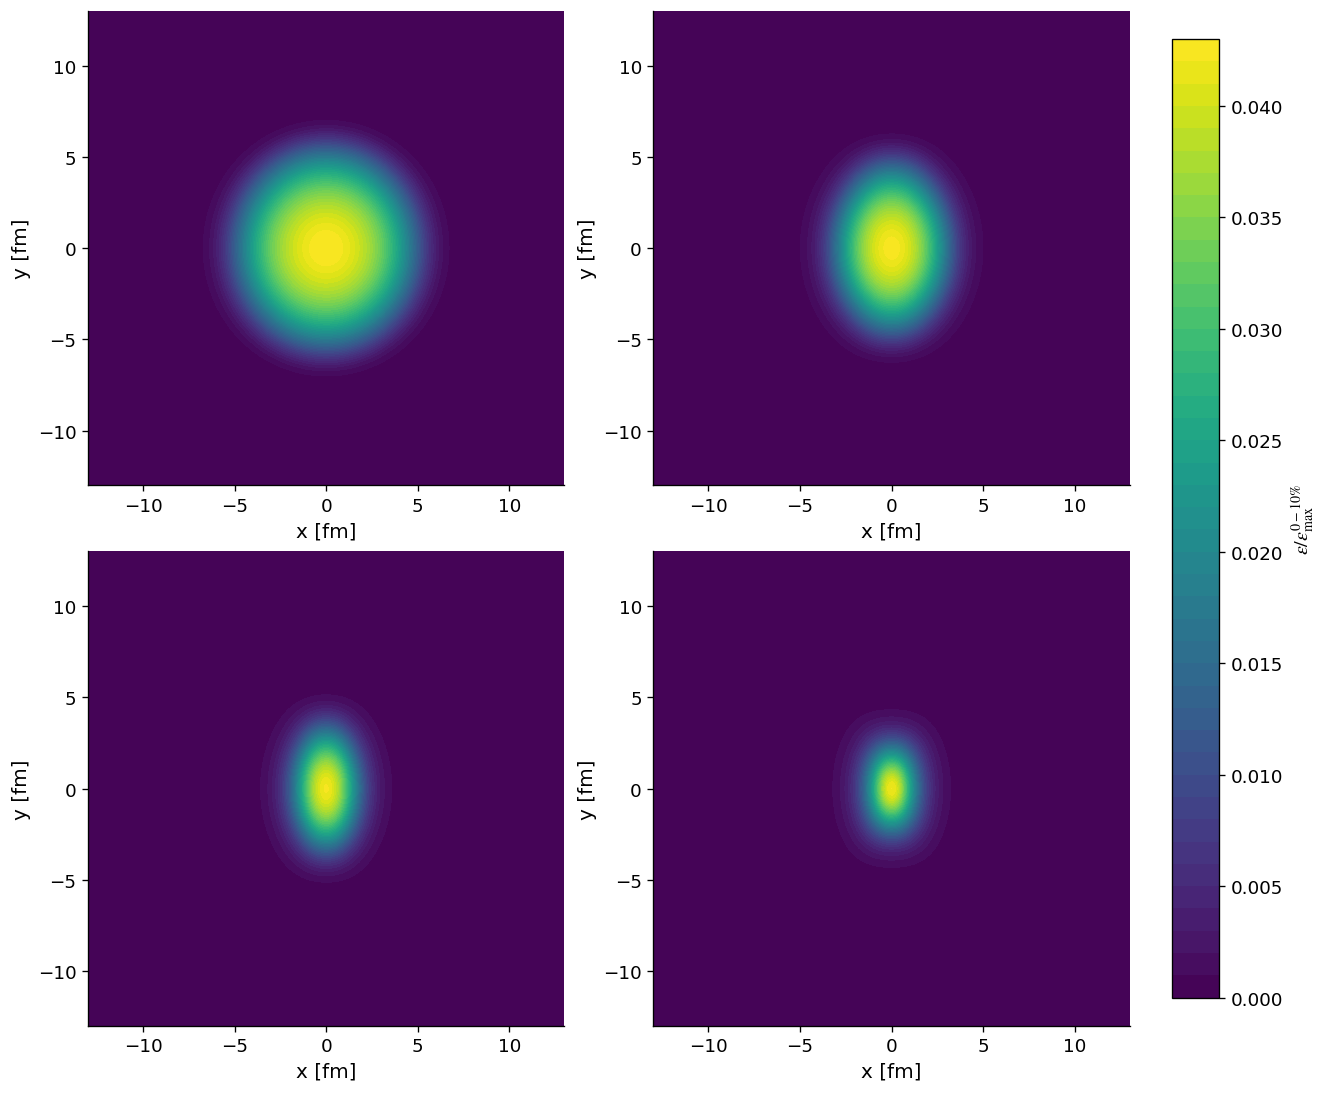

AuAu peak-normalized


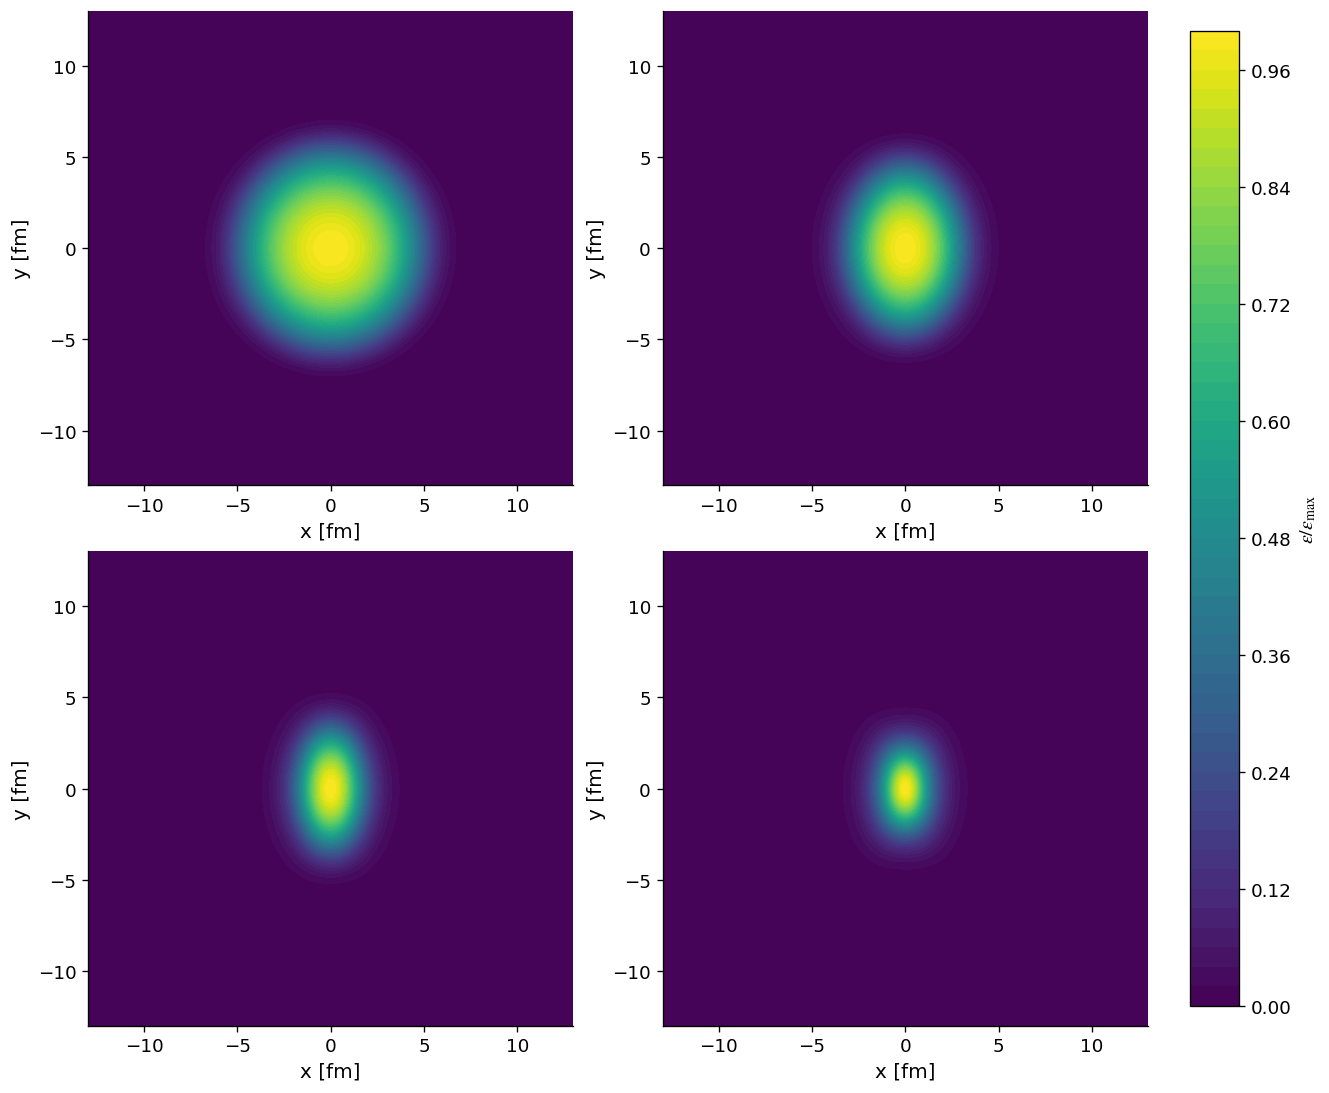

PbPb fixed-scale


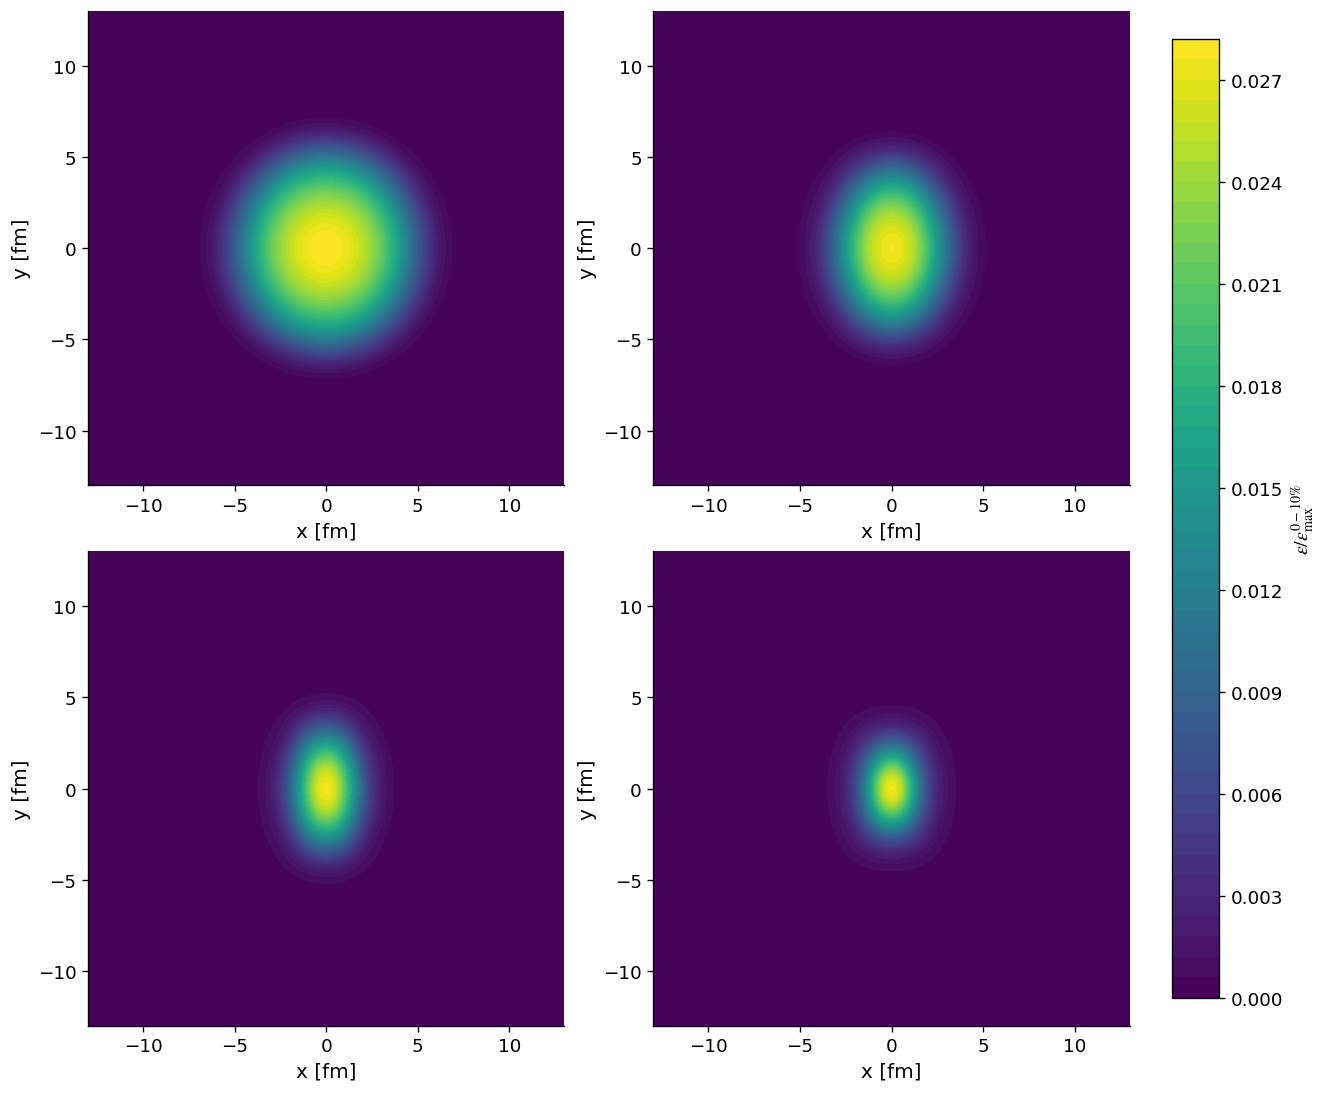

PbPb peak-normalized


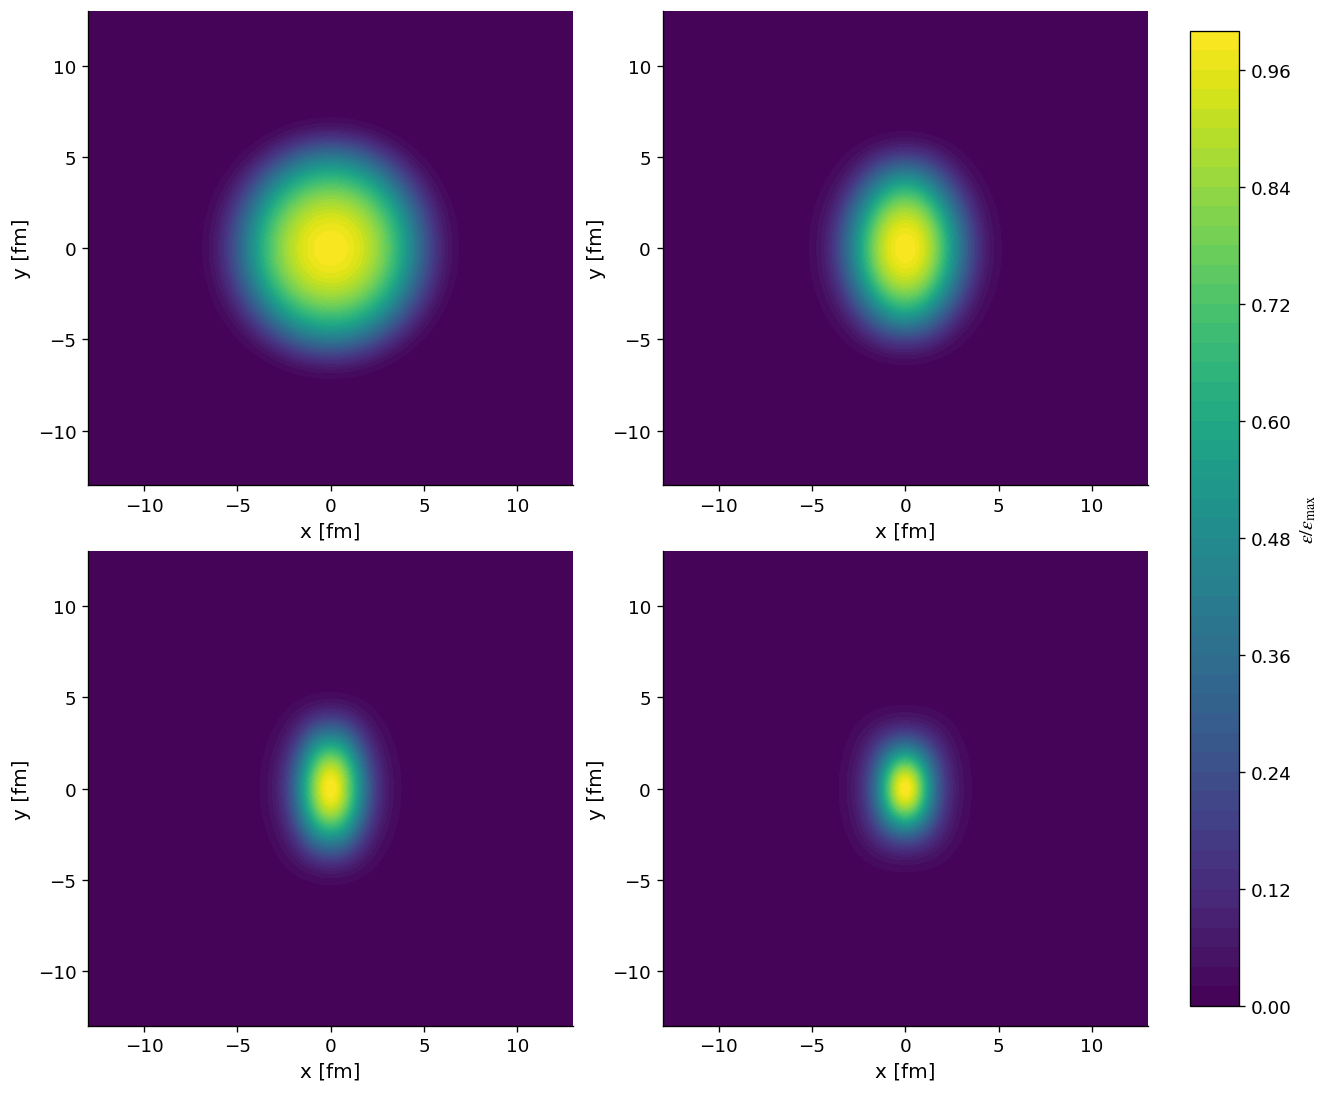

In [4]:

# representative parameters (adjust to match your run cards)
pars_AuAu = TiltedParams(sNN_GeV=200.0,  chi=0.145, Delta_zeta=1.4, sigma_zeta=1.4)
pars_PbPb = TiltedParams(sNN_GeV=5020.0, chi=0.145, Delta_zeta=2.0, sigma_zeta=1.6)

def eps_mid(opt: OpticalGlauber, b: float, pars: TiltedParams):
    Wp, Wt, C = opt.profiles_xy(b, grid)
    return epsilon_tilted_slice(0.0, zeta, Wp, Wt, C, pars)

def show_selected(opt, tab, pars, label, bins=[0,2,5,8], mode="fixed"):
    eps_list = [eps_mid(opt, float(tab["b_mean"][i]), pars) for i in bins]
    ref = np.max(eps_list[0])

    fig, axs = plt.subplots(2, 2, figsize=(11, 9), constrained_layout=True)
    axs = axs.flatten()
    last = None

    for ax, i, eps in zip(axs, bins, eps_list):
        if mode == "fixed":
            Z = eps / ref
            cbar_label = r"$\epsilon/\epsilon^{0-10\%}_{\max}$"
        else:
            Z = eps / np.max(eps)
            cbar_label = r"$\epsilon/\epsilon_{\max}$"

        last = ax.contourf(grid.X, grid.Y, Z, levels=50)
        ax.set_xlabel("x [fm]")
        ax.set_ylabel("y [fm]")
        ax.legend([f"{label}  {CENT[i]}–{CENT[i+1]}%   <b>={tab['b_mean'][i]:.2f} fm"], loc="upper right")
        style_ax(ax)

    fig.colorbar(last, ax=axs, fraction=0.046, pad=0.04, label=cbar_label)
    plt.show()

print("AuAu fixed-scale")
show_selected(opt_AuAu, tab_AuAu, pars_AuAu, "AuAu 200", mode="fixed")

print("AuAu peak-normalized")
show_selected(opt_AuAu, tab_AuAu, pars_AuAu, "AuAu 200", mode="peak")

print("PbPb fixed-scale")
show_selected(opt_PbPb, tab_PbPb, pars_PbPb, "PbPb 5.02", mode="fixed")

print("PbPb peak-normalized")
show_selected(opt_PbPb, tab_PbPb, pars_PbPb, "PbPb 5.02", mode="peak")



## Quantify centrality dependence: peak, integral, and a simple eccentricity ε₂

We compute at ζ=0:

- peak: ε_max
- integral: ∫ d²x ε(x,y)
- ε₂ (participant-plane proxy):
\[
\varepsilon_2 = \frac{\sqrt{\langle r^2\cos 2\phi\rangle^2 + \langle r^2\sin 2\phi\rangle^2}}{\langle r^2\rangle},
\quad \langle \cdots \rangle = \frac{\int d^2x \, \epsilon(x,y)\, (\cdots)}{\int d^2x \, \epsilon(x,y)}.
\]


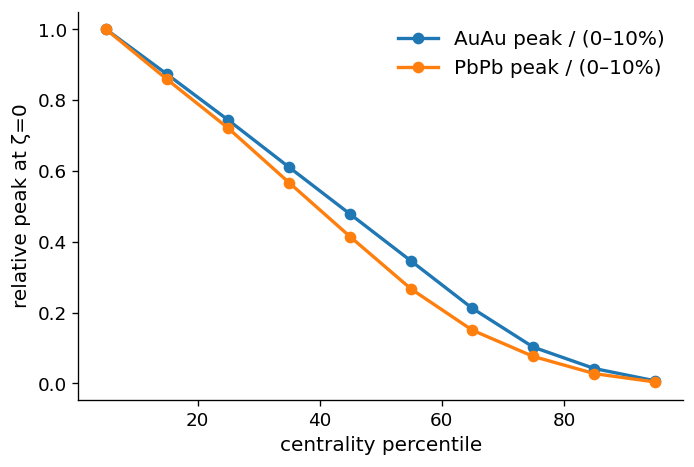

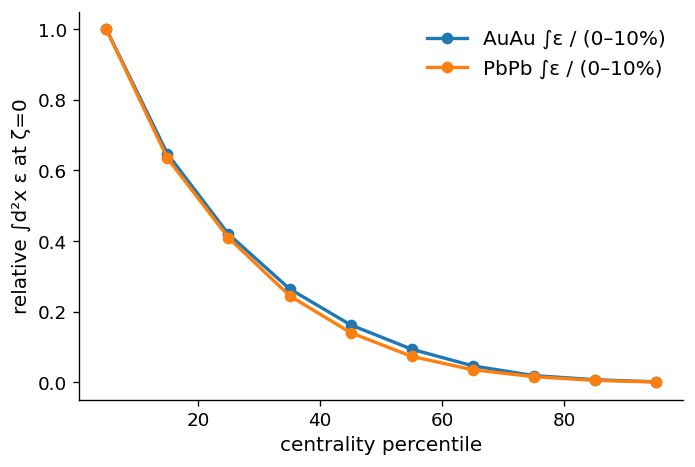

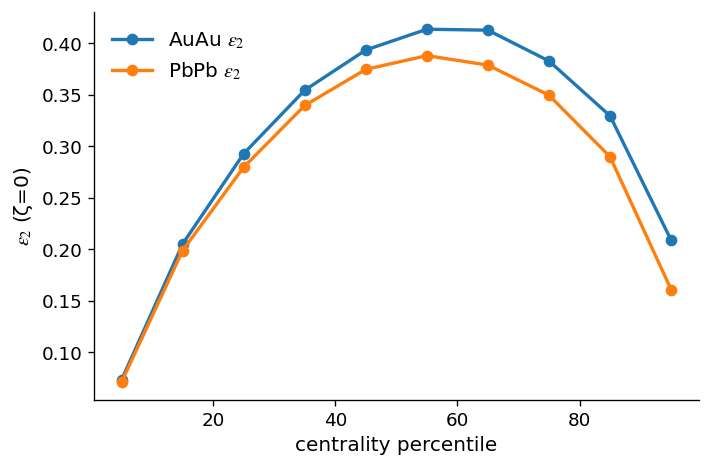

In [5]:

def ecc2(eps_xy):
    X, Y = grid.X, grid.Y
    r2 = X*X + Y*Y
    phi = np.arctan2(Y, X)
    w = eps_xy
    norm = integrate_2d(w, grid)
    if norm <= 0:
        return 0.0
    c = integrate_2d(w * r2 * np.cos(2*phi), grid) / norm
    s = integrate_2d(w * r2 * np.sin(2*phi), grid) / norm
    rr = integrate_2d(w * r2, grid) / norm
    return float(np.sqrt(c*c + s*s) / rr) if rr > 0 else 0.0

def peak_int_ecc(opt, tab, pars):
    pk, I, e2 = [], [], []
    for b in tab["b_mean"]:
        eps = eps_mid(opt, float(b), pars)
        pk.append(float(np.max(eps)))
        I.append(float(integrate_2d(eps, grid)))
        e2.append(ecc2(eps))
    return np.array(pk), np.array(I), np.array(e2)

pk_A, I_A, e2_A = peak_int_ecc(opt_AuAu, tab_AuAu, pars_AuAu)
pk_P, I_P, e2_P = peak_int_ecc(opt_PbPb, tab_PbPb, pars_PbPb)

cent_mid = 0.5*(CENT[:-1] + CENT[1:])

fig, ax = plt.subplots()
ax.plot(cent_mid, pk_A/pk_A[0], marker="o", label="AuAu peak / (0–10%)")
ax.plot(cent_mid, pk_P/pk_P[0], marker="o", label="PbPb peak / (0–10%)")
ax.set_xlabel("centrality percentile")
ax.set_ylabel("relative peak at ζ=0")
ax.legend()
style_ax(ax)
plt.show()

fig, ax = plt.subplots()
ax.plot(cent_mid, I_A/I_A[0], marker="o", label="AuAu ∫ε / (0–10%)")
ax.plot(cent_mid, I_P/I_P[0], marker="o", label="PbPb ∫ε / (0–10%)")
ax.set_xlabel("centrality percentile")
ax.set_ylabel("relative ∫d²x ε at ζ=0")
ax.legend()
style_ax(ax)
plt.show()

fig, ax = plt.subplots()
ax.plot(cent_mid, e2_A, marker="o", label=r"AuAu $\varepsilon_2$")
ax.plot(cent_mid, e2_P, marker="o", label=r"PbPb $\varepsilon_2$")
ax.set_xlabel("centrality percentile")
ax.set_ylabel(r"$\varepsilon_2$ (ζ=0)")
ax.legend()
style_ax(ax)
plt.show()



## Why AA looks so different (physics intuition)

As b increases in AA:
- the **overlap area shrinks** strongly,
- the overlap becomes more **elliptical**,
- eccentricity (and thus anisotropic flow response) increases.

This is a geometric effect of two comparable-size nuclei.
That is exactly why AA centrality classes show strong, visually obvious changes.

In pA, the transverse shape is dominated by the small projectile and changes much less with b,
so **shape-only** plots can look deceptively similar across centrality.
